# Compare alternative decision rules on a value diagram

In [13]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [14]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('..')
from ruv.relative_utility_value import relative_utility_value
from ruv.damage_functions import binary
from ruv.economic_models import cost_loss, cost_loss_analytical_spend
from ruv.utility_functions import cara
from ruv.decision_rules import optimise_over_forecast_distribution, critical_probability_threshold_equals_par, critical_probability_threshold_fixed, critical_probability_threshold_max_value

# Load example forecast dataset

In [15]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE and event frequency for reference

fcst = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')

# use forecasts from first 7 days
fcst = fcst[fcst.index.day <= 7]

# fetch the obs and forecast ensemble
obs = fcst['obs']
fcst = fcst[[col for col in fcst.columns if col.startswith('ens-')]]

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values
ref = None     # RUV library will use obs to replicate event frequency reference as in REV

print(obs.shape, fcst.shape)

(1932,) (1932, 100) (1932, 484)


# Define decision context

In [16]:
alpha_step = 0.02
alphas = np.arange(alpha_step, 1, alpha_step)
decision_threshold = np.nanquantile(obs, 0.75)

decision_context = {
    'damage_function': [binary, {'max_loss': 1, 'min_loss': 0, 'threshold': decision_threshold}],
    'utility_function': [cara, {'A': 0}],
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_thresholds': np.insert([decision_threshold], 0, 0),
}
# note there is no decision_rule defined, we will add this before calling relative_utility_value

# Calculate RUV using different decision rules

In [17]:
parallel_nodes = 8
results = pd.DataFrame(index=alphas, columns=['max value', 'threshold equals alpha', 'fixed threshold 10th', 'fixed threshold 50th', 'fixed threshold 90th', 'full ensemble'])

In [18]:
decision_context['decision_rule'] = [optimise_over_forecast_distribution, None]
results['full ensemble'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [19]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.1}]
results['fixed threshold 10th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [20]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.5}]
results['fixed threshold 50th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [21]:
decision_context['decision_rule'] = [critical_probability_threshold_fixed, {'critical_probability_threshold': 0.9}]
results['fixed threshold 90th'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [22]:
decision_context['decision_rule'] = [critical_probability_threshold_max_value, None]
results['max value'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

In [23]:
decision_context['decision_rule'] = [critical_probability_threshold_equals_par, None]
results['threshold equals alpha'] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

# Plot results on a value diagram

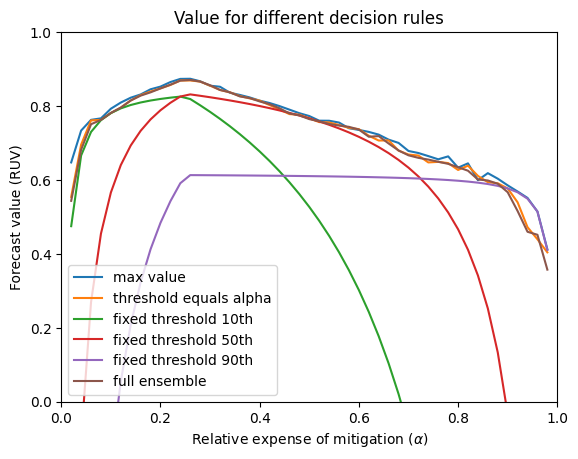

In [24]:
results.plot()
plt.xlim((0, 1))
plt.ylim(0, 1)
plt.xlabel(r'Relative expense of mitigation ($\alpha$)')
plt.ylabel('Forecast value (RUV)') 
plt.title('Value for different decision rules')
plt.legend()